# Apêndice A.

In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

## Importações.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import sys
import PIL
import PIL.Image
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

gpu = tf.test.gpu_device_name()
if gpu == '':
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Treinar/Carregar

In [61]:
flag = 1 #treinar modelo
flag = 0 #carregar modelo !! (Comente para treinar e salvar)

## Configurações.

In [62]:
input_shape = (160,160,3)
batch = 32

vagas = 40
pontos = vagas*4

## Importação do Dataset.

In [63]:
BASE_PATH = ['../..','datasets']
DATASET_DIR=['PKLot','UFPR05']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],
                           DATASET_DIR[0],DATASET_DIR[1])
DATASET_DIR

'../../datasets/PKLot/UFPR05'

In [64]:
IMAGE_DIR = os.path.join(DATASET_DIR,'todas')
XML_DIR = IMAGE_DIR


IMAGE_LIST = []
XML_LIST = []
def criarLista():
    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".jpg"):

            file = os.path.join(IMAGE_DIR,file)
            IMAGE_LIST.append(file)
    IMAGE_LIST.sort()

    for file in os.listdir(IMAGE_DIR):
        if file.endswith(".xml"):

            file = os.path.join(XML_DIR,file)
            XML_LIST.append(file)
    XML_LIST.sort()


criarLista()
#debug
print(IMAGE_DIR)
print(XML_DIR)
print(IMAGE_LIST[:2])
print(XML_LIST[:2])

../../datasets/PKLot/UFPR05/todas
../../datasets/PKLot/UFPR05/todas
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.jpg', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.jpg']
['../../datasets/PKLot/UFPR05/todas/2013-02-22_06_05_00.xml', '../../datasets/PKLot/UFPR05/todas/2013-02-22_06_10_00.xml']


In [65]:
BASE_PATH = ['../..','datasets']
DATASET_DIR=['PKLot','UFPR05']

DATASET_DIR = os.path.join(BASE_PATH[0],BASE_PATH[1],
                           DATASET_DIR[0],DATASET_DIR[1])

DADOS_DIR = os.path.join(DATASET_DIR,'output')
X = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'validation')

class_names = X.class_names


print('\nClasses: {} em {}'.format(X.class_names,DADOS_DIR))

Found 166080 files belonging to 2 classes.
Using 116256 files for training.
Found 166080 files belonging to 2 classes.
Using 49824 files for validation.

Classes: ['livre', 'ocupada'] em ../../datasets/PKLot/UFPR05/output


In [66]:
val_batches = tf.data.experimental.cardinality(X_val)
X_test = X_val.take(val_batches // 5)
X_val  = X_val.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(X_val))
print('Number of test batches: %d' % tf.data.experimental.cardinality(X_test))



Number of validation batches: 1246
Number of test batches: 311


In [67]:
AUTOTUNE = tf.data.AUTOTUNE

#X = X.prefetch(buffer_size=AUTOTUNE)
X_val = X_val.prefetch(buffer_size=AUTOTUNE)
X_test = X_test.prefetch(buffer_size=AUTOTUNE)

## Pre-processamento dos dados.

## Testando os Labels carregadas da base de treinamento.

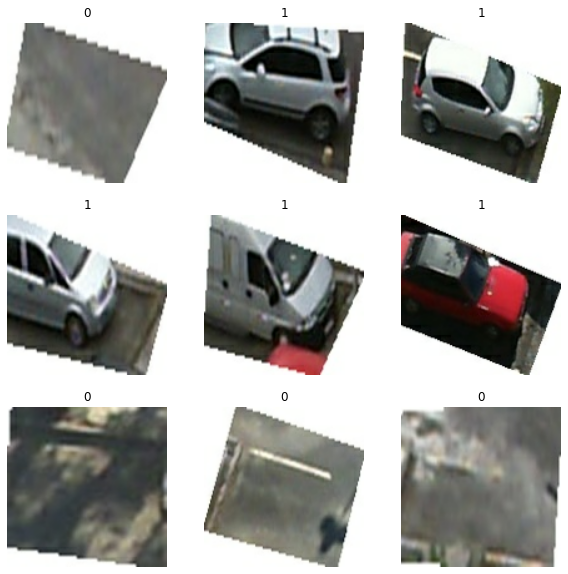

In [68]:
plt.figure(figsize=(10, 10))
for images, labels in X_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Exemplo de Imagem não segmentada.

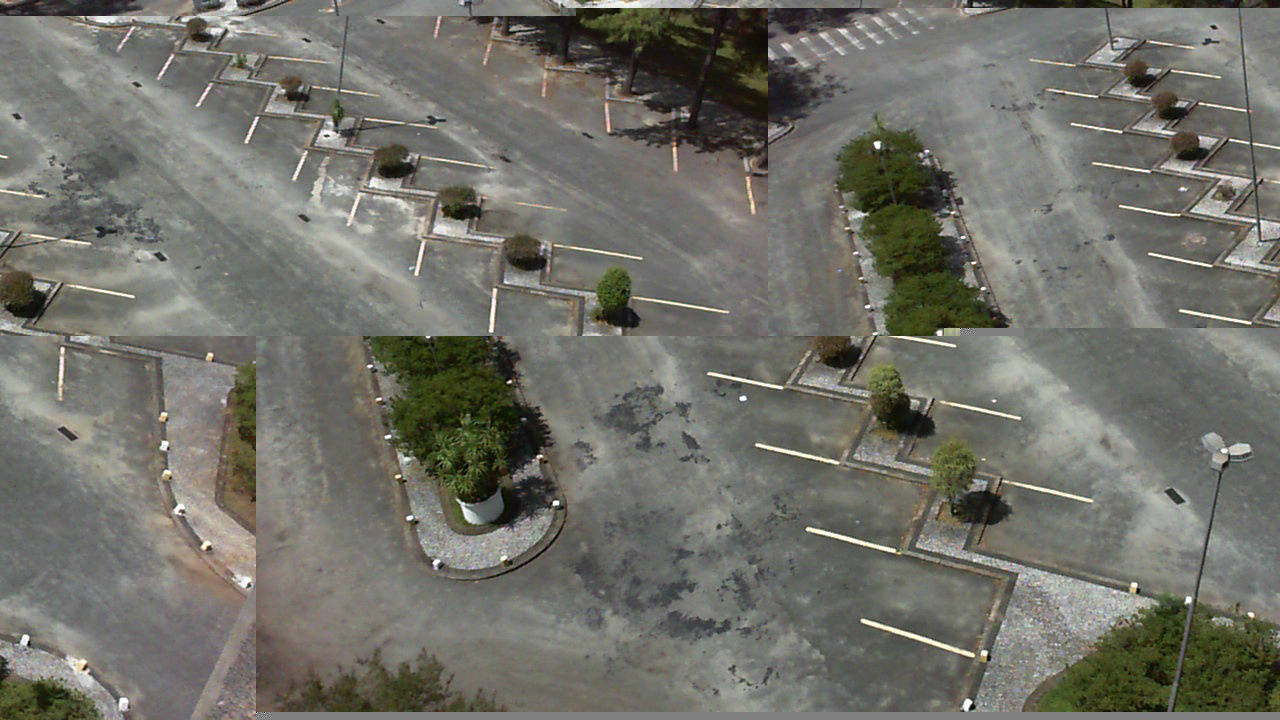

In [69]:
sort = np.random.randint(len(IMAGE_LIST))

PIL.Image.open(IMAGE_LIST[sort])

## Transfer Learning

### Normalizar as imagens para o padrão do modelo da mobilenet_v2

In [70]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [71]:
image_batch, label_batch = next(iter(X))

image_batch[1].shape

TensorShape([160, 160, 3])

### Criar o modelo base.

In [72]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
#base_model.summary()



## Construindo o modelo e compilando.

In [58]:


inputs = tf.keras.Input(shape=(160, 160, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = rescale(x)
x = base_model(x, training=False) # O modelo contem uma camada de Normalização. Não destruir os pesos aprendidos
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy,
              metrics=['accuracy'])

model.summary()

# def modelo():
#     model = keras.Sequential(
#     [
#         layers.InputLayer(input_shape),
#         layers.Conv2D(filters=32,kernel_size=5,strides=2, activation="relu"),
#         layers.Conv2D(32, 3, activation="relu"),
#         layers.MaxPooling2D(pool_size=3),
#         layers.BatchNormalization(),
        
#         layers.Conv2D(32,3, activation="relu"),
#         layers.Conv2D(32,3, activation="relu"),
#         layers.MaxPooling2D(2),
#         layers.BatchNormalization(),
        
#         layers.Flatten(),
#         layers.Dense(48,activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(48,activation='relu'),
#         layers.Dropout(0.3),
#         layers.Dense(1, activation="sigmoid"),
#     ]
# )

#     return model

# #model = modelo()

# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.summary()
# keras.utils.plot_model(model, "./images/arquitetura.png", show_shapes=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

## Treinando o modelo.

In [16]:
%%time

if flag:
    
    loss0, accuracy0 = model.evaluate(X_val)
    
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.2f}".format(accuracy0))
    
    history = model.fit(X, epochs=5, validation_data=X_val)
    
    
else:
    #LOAD_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    LOAD_DIR = os.path.join(DATASET_DIR,'model')

    model = keras.models.load_model(LOAD_DIR)
    

CPU times: user 7.07 s, sys: 92.9 ms, total: 7.17 s
Wall time: 7.14 s


## Métricas

In [17]:
if flag:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,0.1])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Validação do modelo treinado. (testando na base de dados de validação)

In [18]:
if flag:
    score = model.evaluate(X_test, verbose=2)
    print("Test loss:", score[0])
    print("Test accuracy:", score[1])

## Salvando o modelo treinado.

In [19]:
if flag:
    SAVE_DIR = os.path.split(DATASET_DIR)[0] # Separa (head,tail) -> Indice [0] = head
    SAVE_DIR = os.path.join(DATASET_DIR,'model')
    model.save(
        SAVE_DIR,
        overwrite=False,
        include_optimizer=True,
        save_format=None,
        signatures=None,
        options=None,
        save_traces=True,
    )

## Validação individual (random) na base de treinamento

In [20]:
X = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'training')


X_val = tf.keras.preprocessing.image_dataset_from_directory(DADOS_DIR, image_size=input_shape[:2], batch_size=batch, label_mode='binary',
                                                        shuffle=True, seed=123, color_mode='rgb', validation_split=0.3, subset = 'validation')

Found 166080 files belonging to 2 classes.
Using 116256 files for training.
Found 166080 files belonging to 2 classes.
Using 49824 files for validation.


Vaga livre: 100.00 porcento.
Vaga ocupada 0.00 porcento.


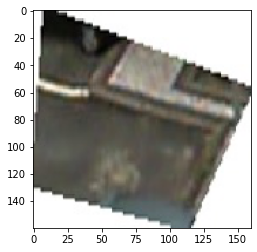

In [21]:
path = X.file_paths[np.random.randint(len(X.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

plt.imshow(img)

## Validação individual (random) no Banco de testes

Vaga livre: 0.00 porcento.
Vaga ocupada 100.00 porcento.


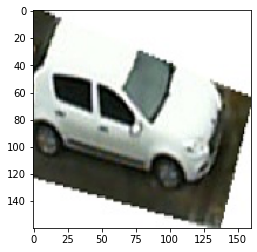

In [22]:
path = X_val.file_paths[np.random.randint(len(X_val.file_paths))]
img = keras.preprocessing.image.load_img(path, target_size=input_shape[:2])
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array,  0)

predictions = model.predict(img_array)

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

score = predictions[0]

print(
    'Vaga livre: %.2f porcento.\nVaga ocupada %.2f porcento.'
    % (100 * (1 - score), 100 * score)
)

plt.imshow(img)


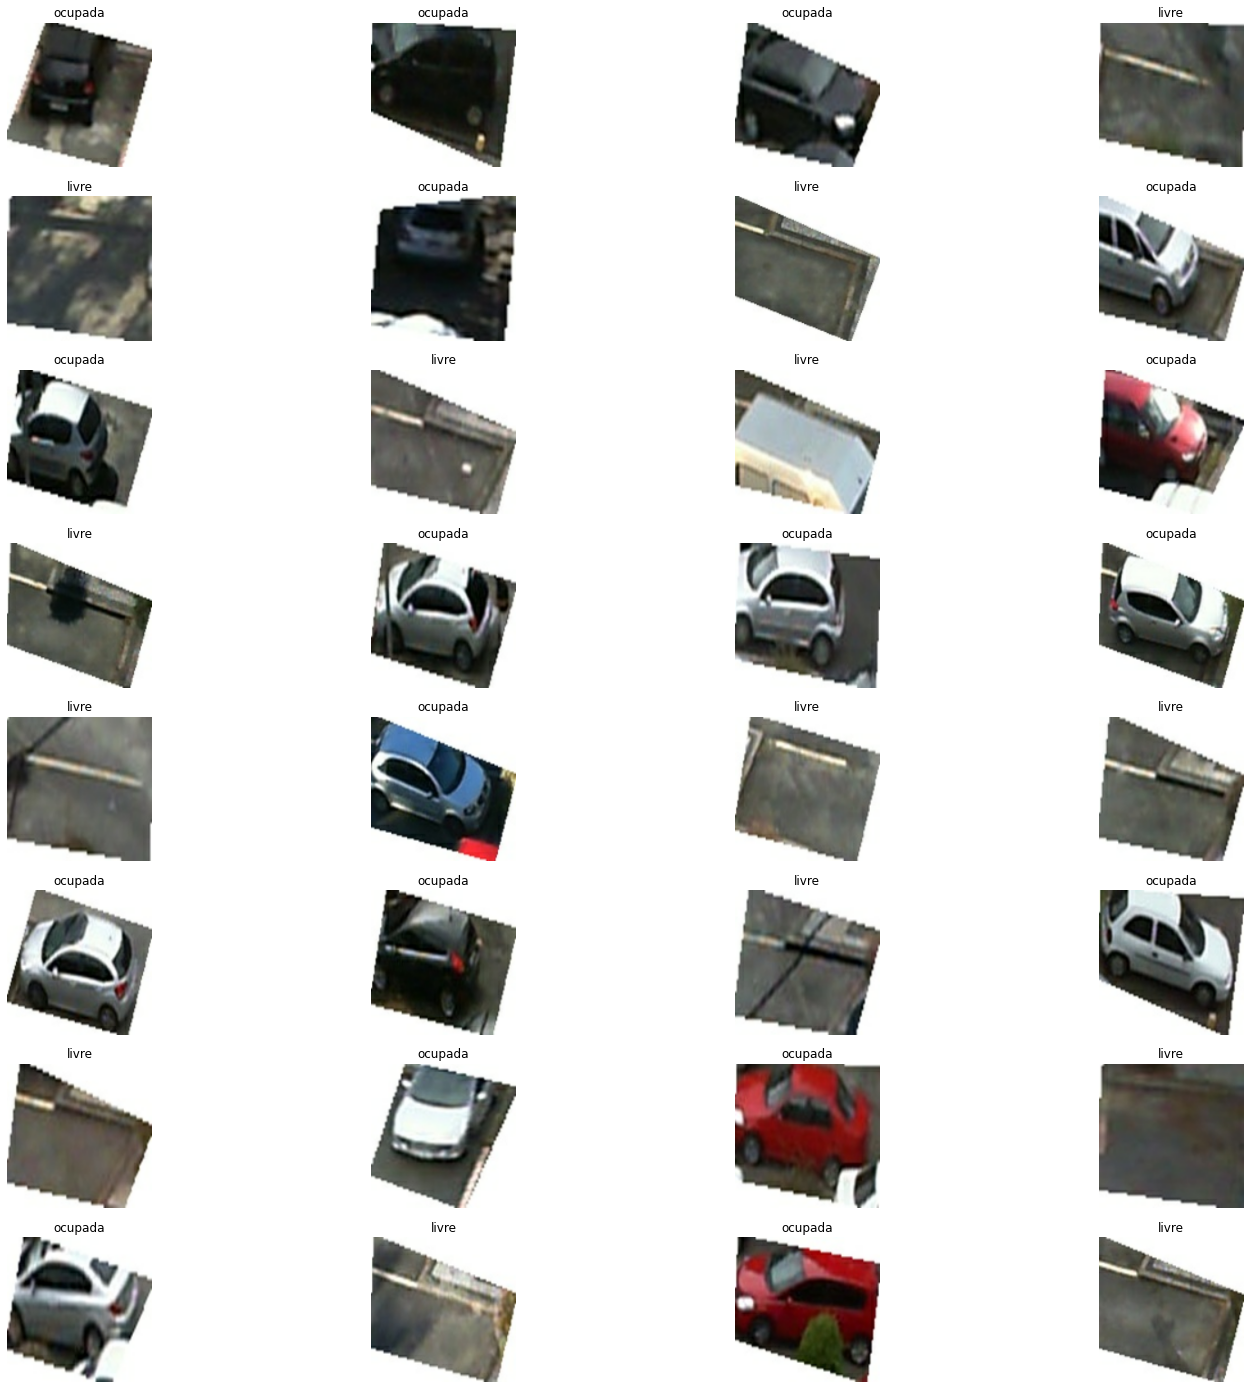

In [40]:
#Retrieve a batch of images from the test set
image_batch, label_batch = X_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

for i in range (len(predictions)):
    #print('\nPredictions = {}, {} = Label'.format(predictions[i].numpy(),label_batch[i].tolist()))
    pass

plt.figure(figsize=(25, 25))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## CARREGANDO XML E CRIANDO OS PONTOS

In [24]:
tree = ET.parse(XML_LIST[0])
root = tree.getroot()

pts = np.empty(0,np.int32)
vaga = np.empty(0,np.int32)

for neighbor in root.iter('point'):
    #print(neighbor.attrib)
    x,y = neighbor.attrib.values()
    x = int(x)
    y = int(y)
    a = [x,y]
    pts = np.append(pts,[x,y])
    
for neighbor in root.iter('space'):
    #print(neighbor.attrib)
    if(len(neighbor.attrib.values())==2):
        _,occupied = neighbor.attrib.values()
        occupied = int(occupied)
    if(len(neighbor.attrib.values())==1):
        occupied=0
        
    vaga = np.append(vaga,occupied)

#debug
print(pts[0:4])
print(vaga[0:40])

paresXY = np.array(np.zeros((pontos,2)),np.int32) 
j=0
for i in range(pontos):
    paresXY[i] = pts[j:j+2]
    j = j+2

#debug
paresXY[0:4]

[608 613 741 654]
[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


array([[608, 613],
       [741, 654],
       [775, 582],
       [608, 526]], dtype=int32)

In [25]:
def crop(j=0,i=0):
    rect = cv2.boundingRect(paresXY[j:j+4])
    x,y,w,h = rect
    croped = im[y:y+h, x:x+w].copy()

    pts = paresXY[j:j+4] - paresXY[j:j+4].min(axis=0)
    mask = np.zeros(croped.shape[:2], croped.dtype)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask) #background preto

    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg+ dst #background branco
    
    image = cv2.resize(dst2, input_shape[:2], interpolation = cv2.INTER_CUBIC)
    
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,  0)

    predictions = model.predict(img_array)
     
    score = predictions[0]
    score = float(score)
    return score
    

In [26]:
def juntar(im2,im,scale=80):
    
    img = np.hstack((im2, im))
    
    scale_percent = scale # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)  
    return resized

## Defina o número de Vagas (0-37)

In [36]:
nVagas = 5
nVagas = vagas - nVagas

## Varias imagens.

In [38]:
for i in range (1): #só repetição
    
    sort = np.random.randint(len(IMAGE_LIST))
    im = cv2.imread(IMAGE_LIST[sort])
    im2 = im.copy()
    if im is None:
        sys.exit("A imagem não foi carregada.")

    j=0
    contador = 0
    for i in range(nVagas,len(paresXY)//4):

        score = crop(j,i)
        #print(score)
        if((score)<0.0):
            cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
            contador = contador +1
            #print(score)
        j=j+4
        
        

    cv2.putText(im,str(contador),(10,700), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5,cv2.LINE_AA)
    img_junta = juntar(im2,im,70)

    cv2.imshow(IMAGE_LIST[sort], img_junta)
    k = cv2.waitKey(0)
    cv2.destroyAllWindows()
# if k == ord('q'):
#     cv2.destroyAllWindows()

#image = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
#plt.imshow(image)

## VIDEO

In [39]:
VIDEO_FILE = os.path.join(DATASET_DIR,'pklot.mp4')
cap = cv2.VideoCapture(VIDEO_FILE)

if cap.isOpened() == False:
    print('Video não encontrado.')

while(cap.isOpened()):
    ret, im = cap.read()
    height, width, _ = im.shape
    
    if ret == True:
    
        j=0
        contador = 0
                
    
        for i in range(nVagas,len(paresXY)//4):
            
            score = crop(j,i)
            #print(score)
            if((score)<0.0):
                cv2.polylines(im,[paresXY[j:j+4]],True,(0,255,255),2)
                contador = contador +1
                #print(score)
            j=j+4
        
        cv2.putText(im,str(contador),(10,700), cv2.FONT_HERSHEY_SIMPLEX, 4,(255,255,255),5,cv2.LINE_AA)
        cv2.imshow('Estacionamento', im)
        
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    
    else:
        break
cap.release()
cv2.destroyAllWindows()

## Debug 

(-0.5, 1279.5, 719.5, -0.5)

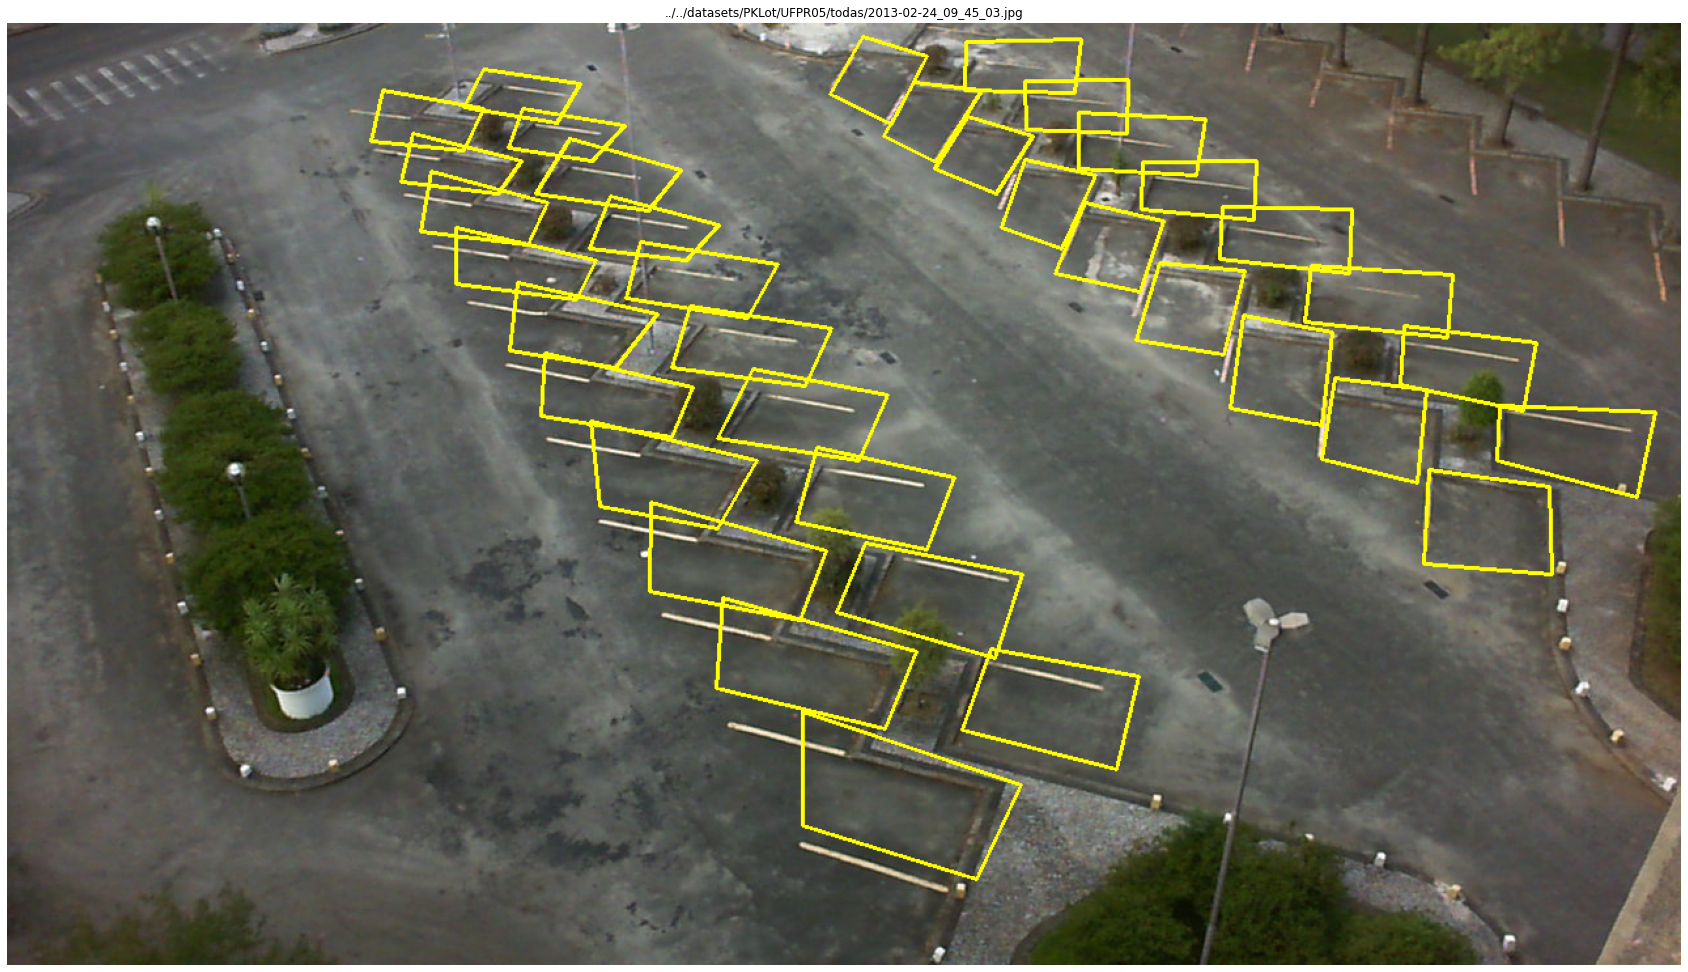

In [30]:
im = plt.imread(IMAGE_LIST[450])
j=0
contador = 0
for i in range(nVagas,len(paresXY)//4):

    score = crop(j,i)
    #print(score)
    if((score)<0.0):
        cv2.polylines(im,[paresXY[j:j+4]],True,(255,255,0),2)
        contador = contador +1
        #print(score)
    j=j+4

fig = plt.figure(figsize=(30, 30))
#image = plt.imread(IMAGE_LIST[350])
#im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.title(IMAGE_LIST[350])
plt.axis("off")